## Imports

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as pplt
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [4]:
def minusTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date- timedelta(days = t)
    return d.strftime('%Y-%m-%d')

def addTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')

In [5]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start, beta_start, gamma_start, rho_start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDeath"].to_numpy()
    time = np.linspace(offset,offset+len(data)-1, len(data))

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/10000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.036, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.047, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)
        
        reproduciton = pm.Deterministic('R0', beta/gamma)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=1000, tune=1000, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

In [6]:
def runMCMC(df, population, start_date, end_date, offset, beta, gamma, rho):
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    mcmc = sampleMCMC(offset,df,population, 3, beta, gamma, rho)
    return mcmc    

In [7]:
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['i0','beta','gamma','rho','sigma','R0'], round_to=5))
    return results

In [8]:
def plotMCMC(model):
    plot_trace = pm.plot_trace(model, var_names=('beta','gamma','rho','R0'), legend=True, chain_prop={"color":"rgbym"},figsize=(10.0,15.0))
    plot_pair = pm.plot_pair(model, var_names=('beta','gamma'), kind='kde')
    return plot_trace, plot_pair

## Preparing 

In [9]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-03-03','2020-03-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           }
}

# Preparing Beta, Gamma, Rho values
beta = [0.030, 0.032, 0.035, 0.037]
gamma = [0.038, 0.040, 0.044, 0.036]
rho = [0.030, 0.032, 0.035, 0.037]

## Running Analysis

### First Lockdown

In [10]:
country_names = ['France','Germany','Italy','Spain','UK']
quarantine_one_results = []
for country in country_names:
    df = dataset[country]['data']
    pop = dataset[country]['pop']
    date = dataset[country]['fLock'][0]
    result = []

    # Before Lockdown
    try:
        result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[0],gamma[2],rho[0]))
            except:
                try:
                    result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[3],gamma[3],rho[3]))
                except:
                    next
    
    # After Lockdown
    try:
        result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[0],gamma[2],rho[0]))
            except:
                    try:
                        result.append(runMCMC(df,pop,date,addTime(date,40),15,beta[3],gamma[3],rho[3]))
                    except:
                        next

    quarantine_one_results.append(result)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


#### Store parameter values

In [11]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_before = results_before.loc[["beta","gamma","rho",'i0','R0']]
    results_before.to_csv('mcmc_data/' + country_names[index] + '/fLock_before.csv')

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_after = results_after.loc[["beta","gamma","rho",'i0','R0']]
    results_after.to_csv('mcmc_data/' + country_names[index] + '/fLock_after.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


#### Print Parameter Values (Full)

In [14]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    print(country_names[index])
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_before)

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_after)

Got error No model on context stack. trying to find log_likelihood in translation.


France


mean        sd      hdi_3%     hdi_97%    r_hat
i0     6740.32160  83.03545  6591.00000  6893.00000  1.00559
beta      0.18941   0.01144     0.17184     0.20645  1.00819
gamma     0.03200   0.01194     0.01610     0.05105  1.00976
rho       0.03679   0.00933     0.01809     0.05332  1.00832
sigma   316.24730  59.72044   216.42256   429.51555  1.00085
R0        6.43699   1.67246     3.33126     9.39151  1.00932

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6745.57400   81.07385  6584.00000  6892.00000  1.00669
beta      0.35999    0.08645     0.22537     0.51173  1.00318
gamma     0.30619    0.08851     0.16611     0.46116  1.00335
rho       0.04350    0.00900     0.02586     0.06017  1.00264
sigma  2183.41480  289.82156  1666.93134  2717.48835  1.00328
R0        1.19093    0.06127     1.08842     1.30878  1.00288

Got error No model on context stack. trying to find log_likelihood in translation.


Germany


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8303.05160  92.18455  8127.00000  8469.00000  1.00305
beta      0.15546   0.00927     0.14019     0.17257  1.00393
gamma     0.03075   0.00970     0.01556     0.04859  1.00144
rho       0.03648   0.00920     0.01929     0.05315  1.00282
sigma   200.39743  36.57615   138.77695   266.02033  1.00195
R0        5.45193   1.41115     3.09353     8.16054  1.00085

Got error No model on context stack. trying to find log_likelihood in translation.


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8303.63120  89.64068  8121.00000  8462.00000  1.01015
beta      0.19616   0.04037     0.13309     0.26925  1.00336
gamma     0.15932   0.04201     0.09307     0.23645  1.00323
rho       0.04362   0.00892     0.02851     0.06185  1.00261
sigma   803.85086  98.04609   634.02848   992.49479  1.00155
R0        1.24860   0.07723     1.11570     1.38963  1.00192

Got error No model on context stack. trying to find log_likelihood in translation.


Italy


mean        sd      hdi_3%     hdi_97%    r_hat
i0     5915.82820  79.79254  5771.00000  6067.00000  1.01651
beta      0.22873   0.02710     0.18601     0.27859  1.00343
gamma     0.11260   0.02841     0.06638     0.16480  1.00321
rho       0.04161   0.00878     0.02569     0.05847  1.00233
sigma   377.44123  67.09761   265.65114   506.44209  1.00299
R0        2.09654   0.27969     1.58565     2.61168  1.00327

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     5914.65720   78.06955  5775.00000  6068.00000  1.00550
beta      0.56148    0.13451     0.35545     0.80414  1.01069
gamma     0.51993    0.13571     0.30752     0.76164  1.01054
rho       0.04409    0.00908     0.02692     0.06084  1.01132
sigma  1706.70069  206.93174  1340.81484  2080.72250  1.00296
R0        1.08539    0.02378     1.04401     1.12975  1.00886

Got error No model on context stack. trying to find log_likelihood in translation.


Spain


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4745.22360   71.40362  4610.00000  4870.00000  1.00795
beta      0.22202    0.02131     0.18959     0.26330  1.00276
gamma     0.08056    0.02464     0.03918     0.12575  1.00255
rho       0.04031    0.00912     0.02323     0.05691  1.00257
sigma   606.41842  114.91169   419.38854   827.48345  1.00319
R0        2.93502    0.66596     1.84543     4.19176  1.00201

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4745.02040   69.02645  4622.00000  4887.00000  1.00938
beta      0.65419    0.15815     0.39139     0.94638  1.02766
gamma     0.61200    0.15998     0.34856     0.91591  1.02756
rho       0.04497    0.00924     0.02736     0.06188  1.02473
sigma  2163.29142  276.12617  1684.03999  2696.11482  1.00509
R0        1.07429    0.02359     1.03360     1.11734  1.02360

Got error No model on context stack. trying to find log_likelihood in translation.


UK


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6733.32440   81.94377  6582.00000  6886.00000  1.00562
beta      0.31999    0.05103     0.23848     0.41544  1.00550
gamma     0.21064    0.05273     0.12519     0.31191  1.00507
rho       0.04318    0.00887     0.02722     0.06053  1.00608
sigma   772.51066  135.91904   550.93215  1021.53451  1.00443
R0        1.55198    0.14356     1.29799     1.82426  1.00417

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6733.52580   84.44916  6575.00000  6888.00000  1.01211
beta      0.87960    0.16610     0.58910     1.20027  1.02609
gamma     0.84084    0.16725     0.55030     1.16881  1.02541
rho       0.04592    0.00827     0.03123     0.06190  1.02040
sigma  2977.39465  355.85664  2328.35076  3656.67765  1.00647
R0        1.04825    0.01199     1.02778     1.06971  1.01574

#### Graph Results of Analysis

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got 

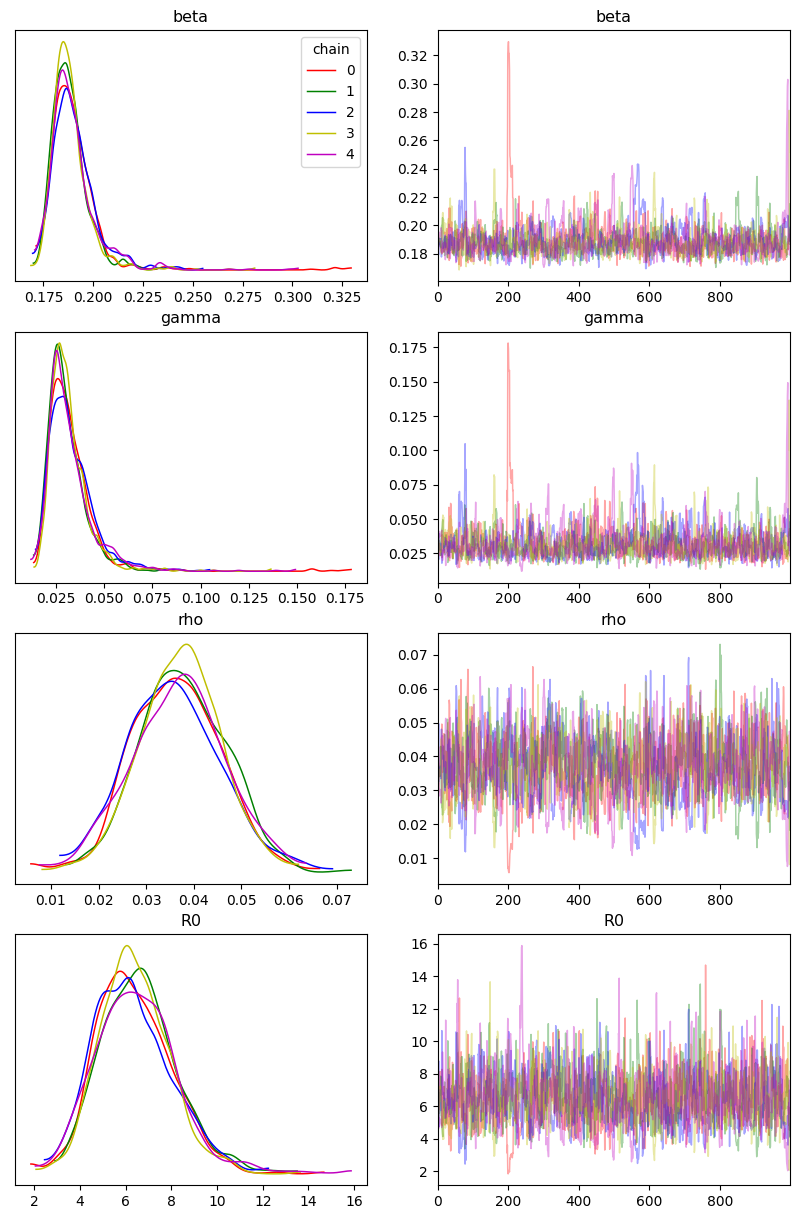

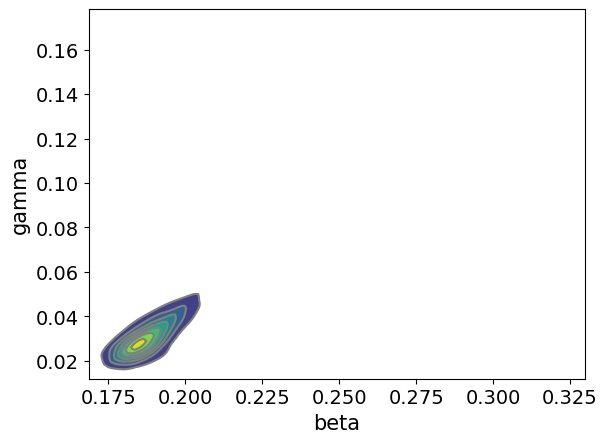

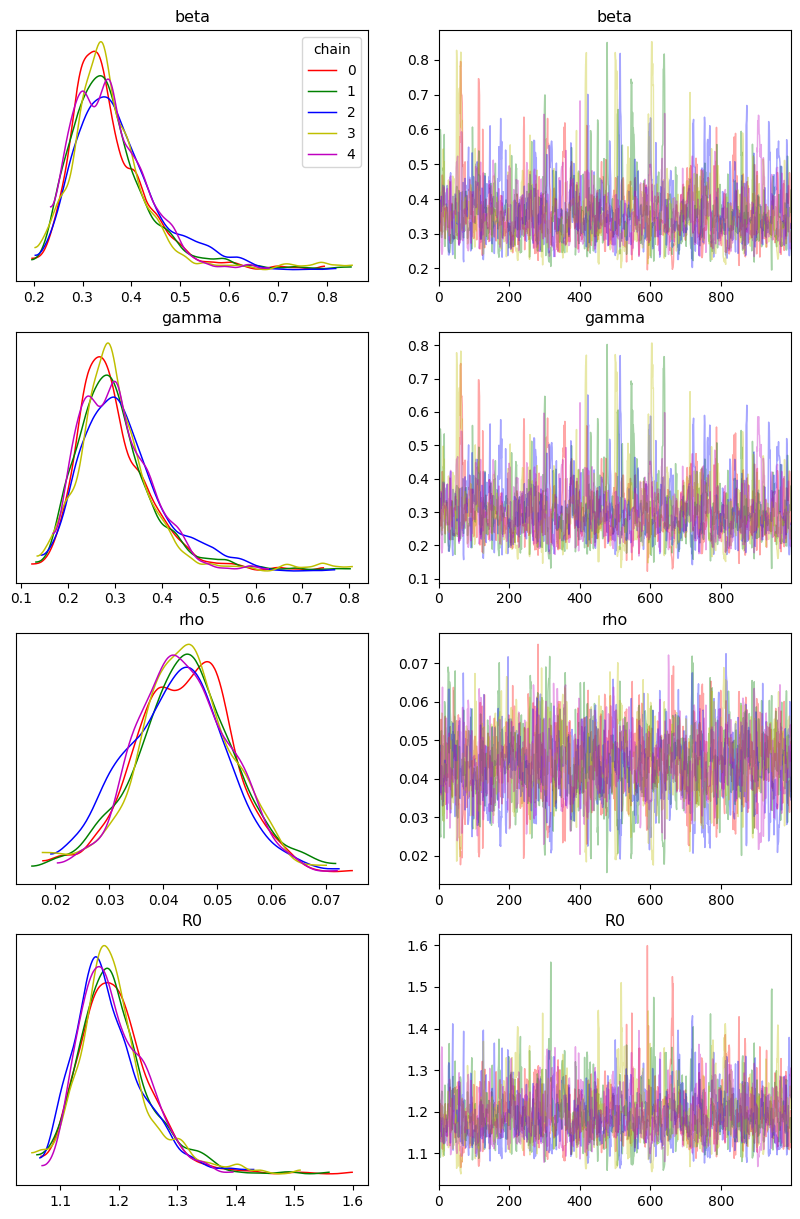

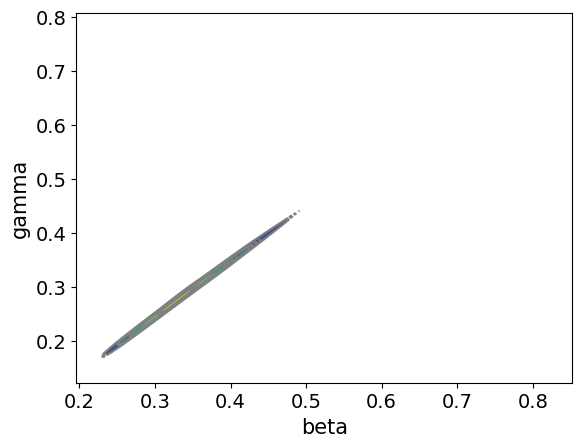

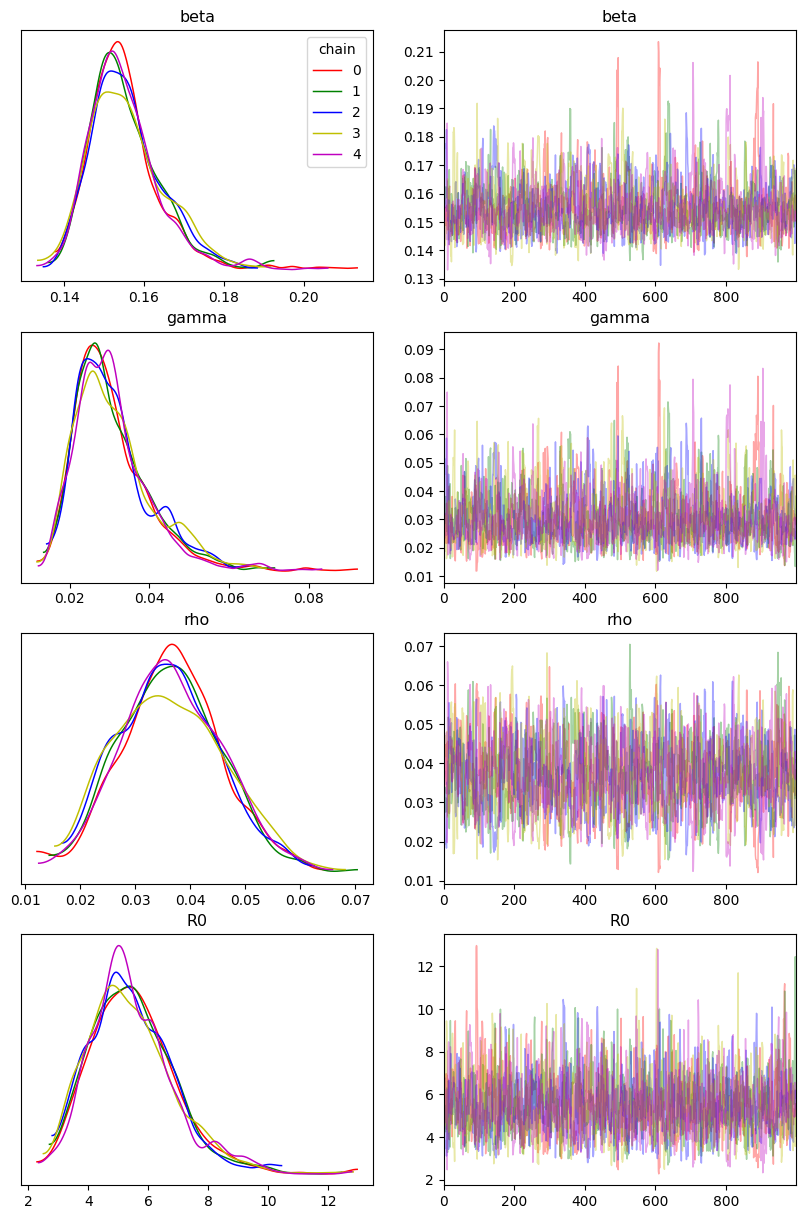

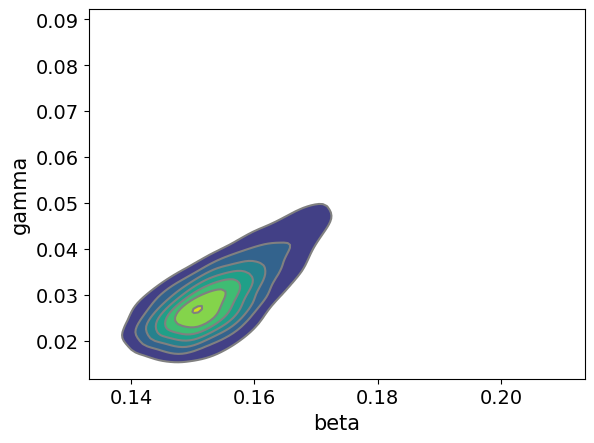

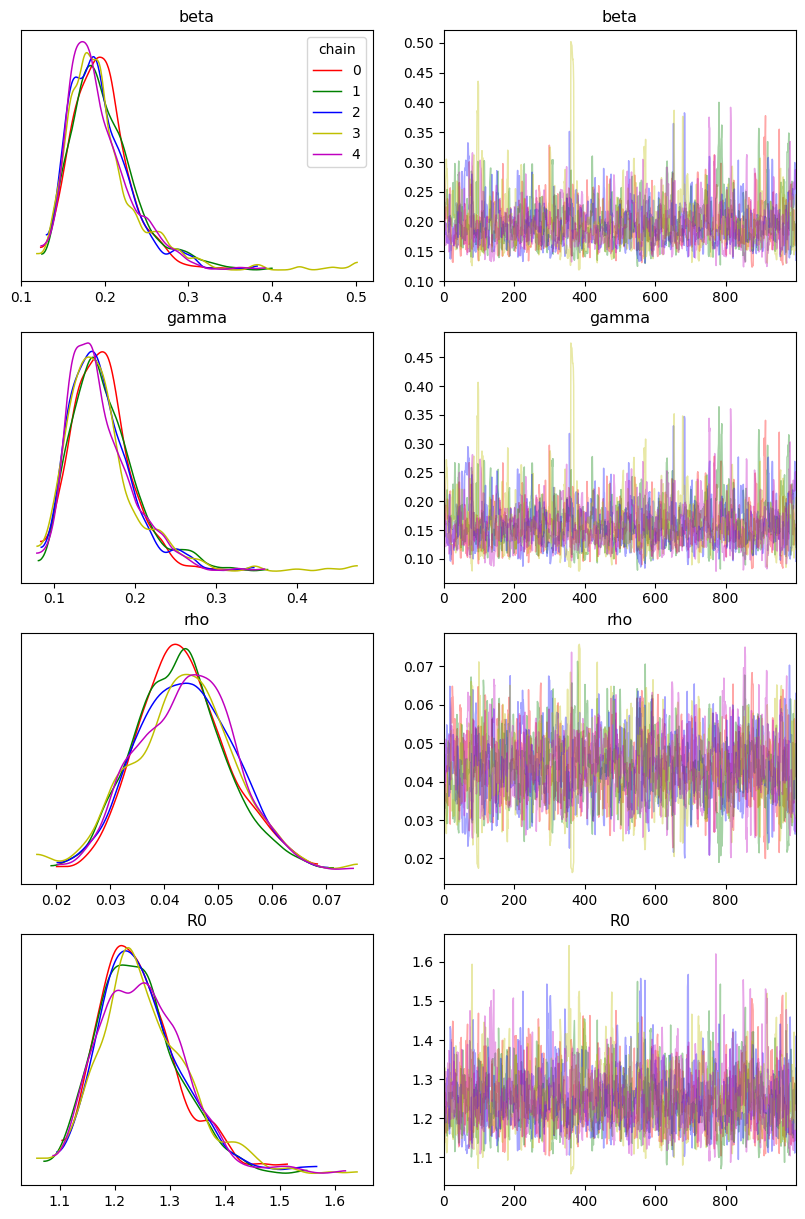

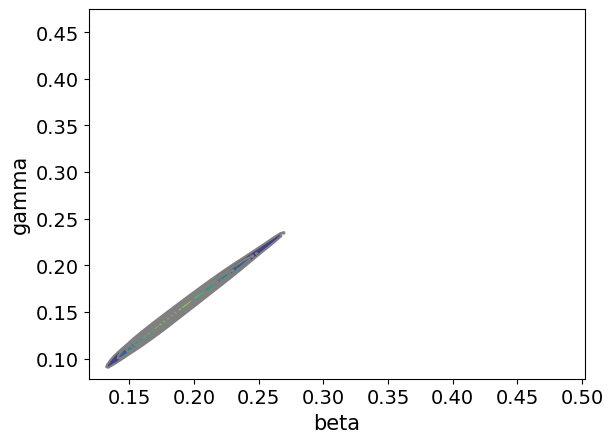

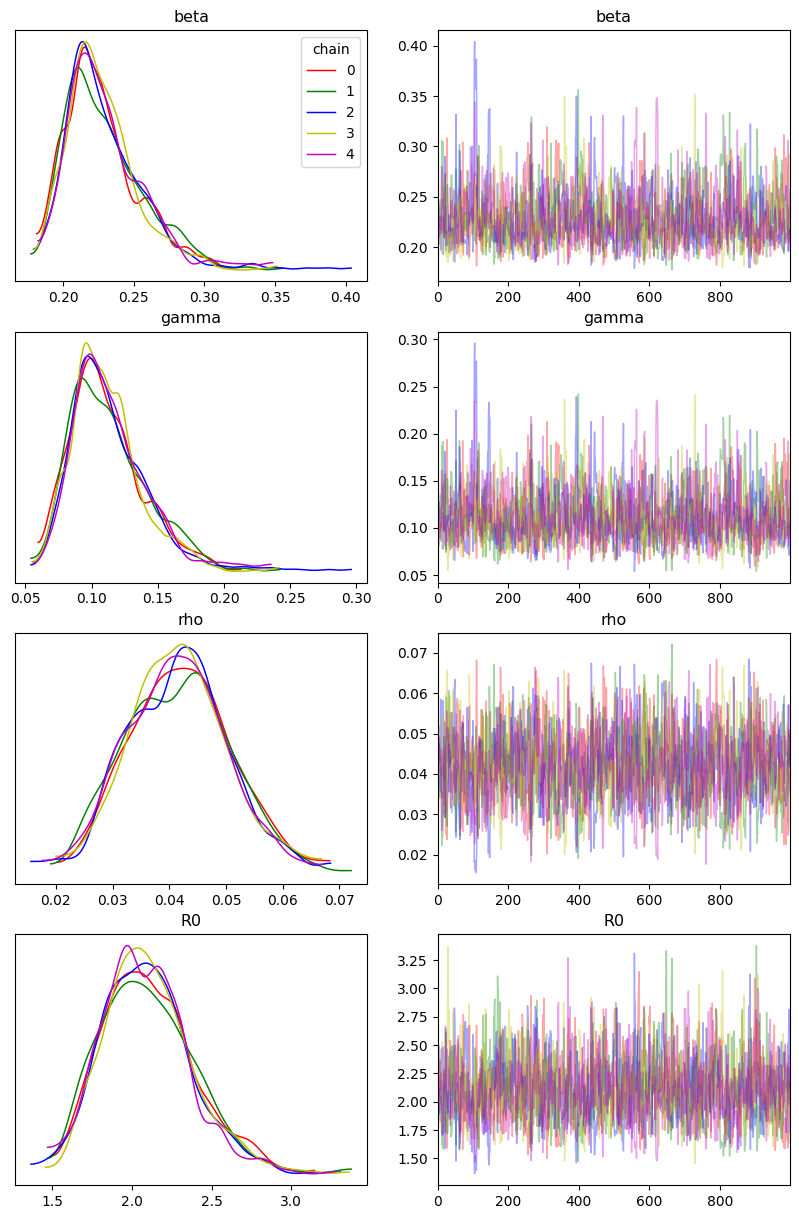

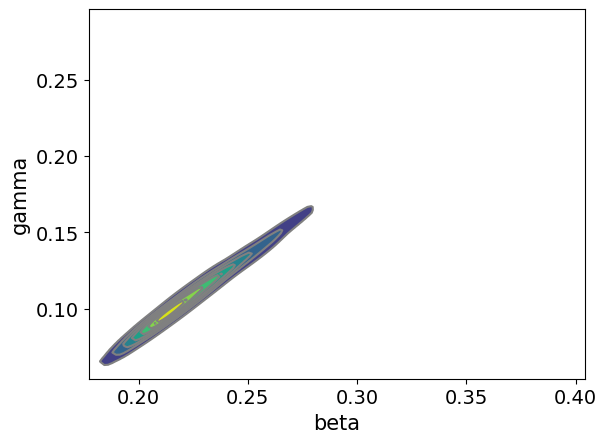

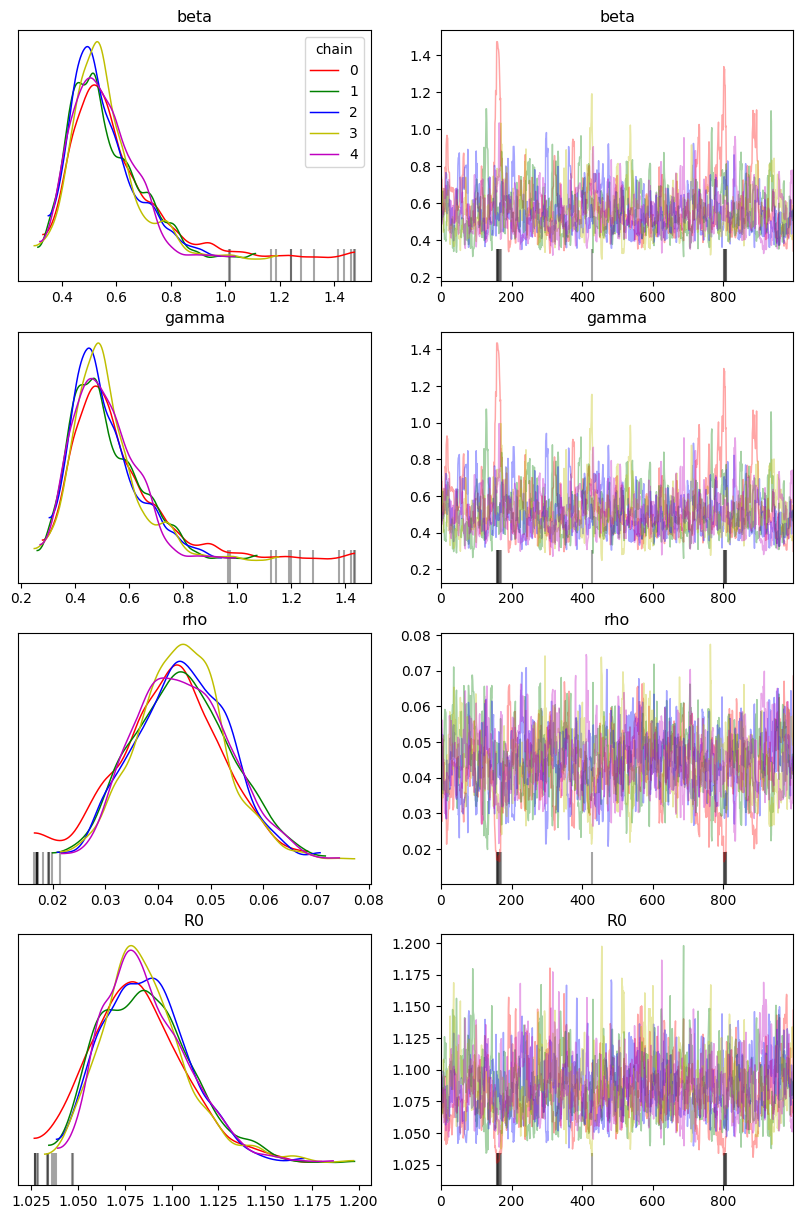

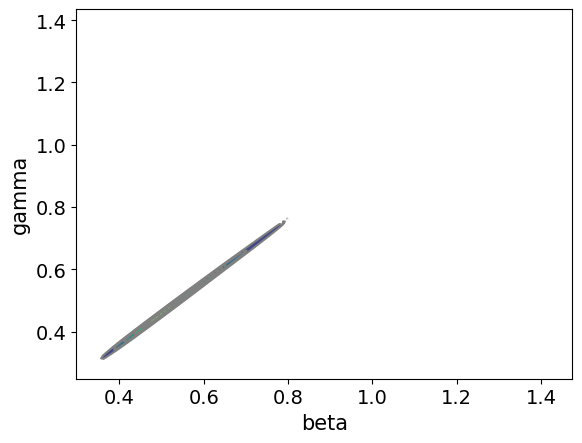

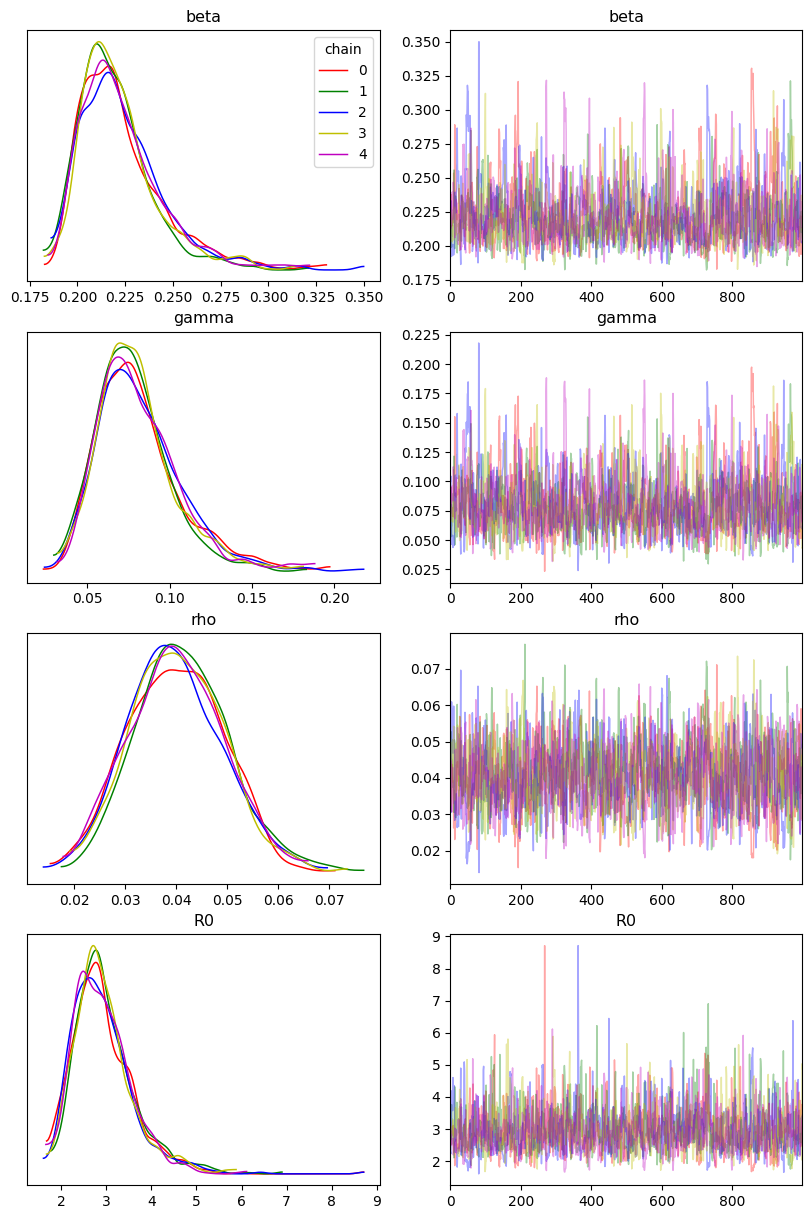

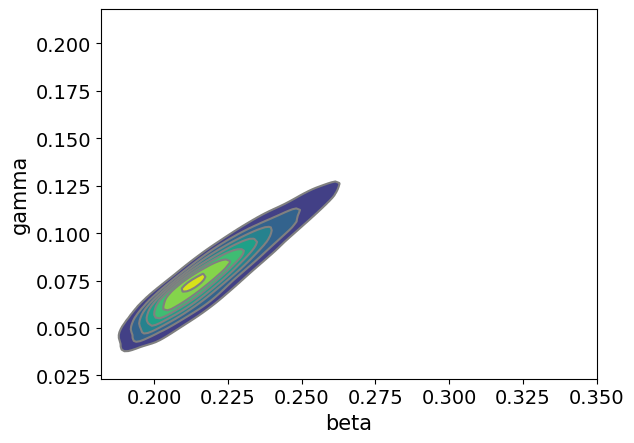

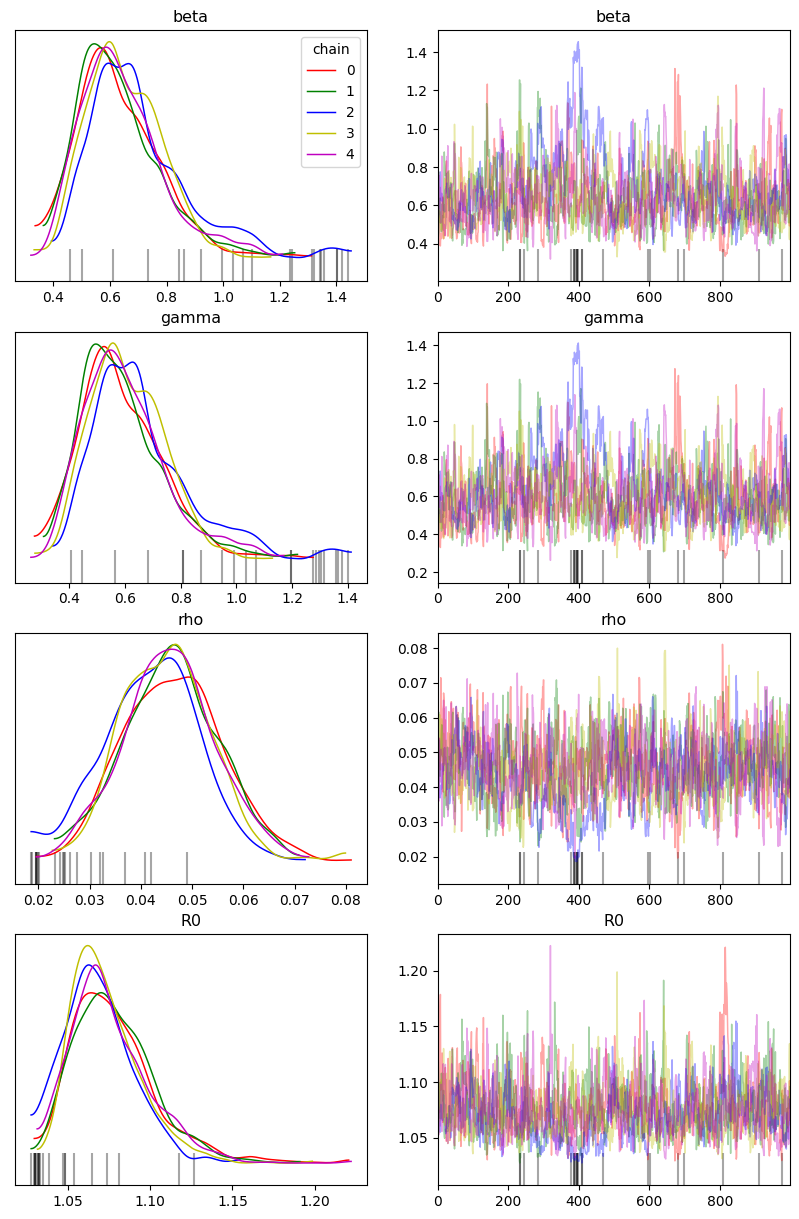

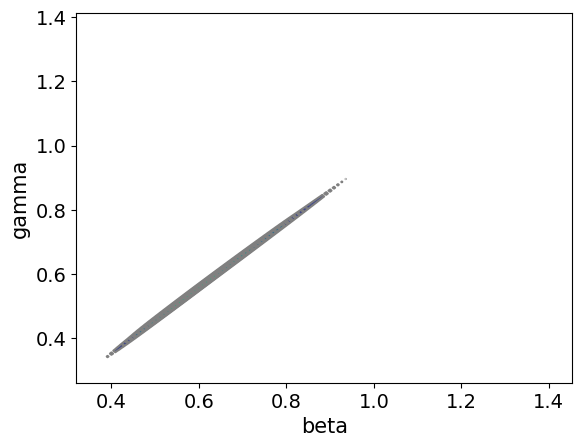

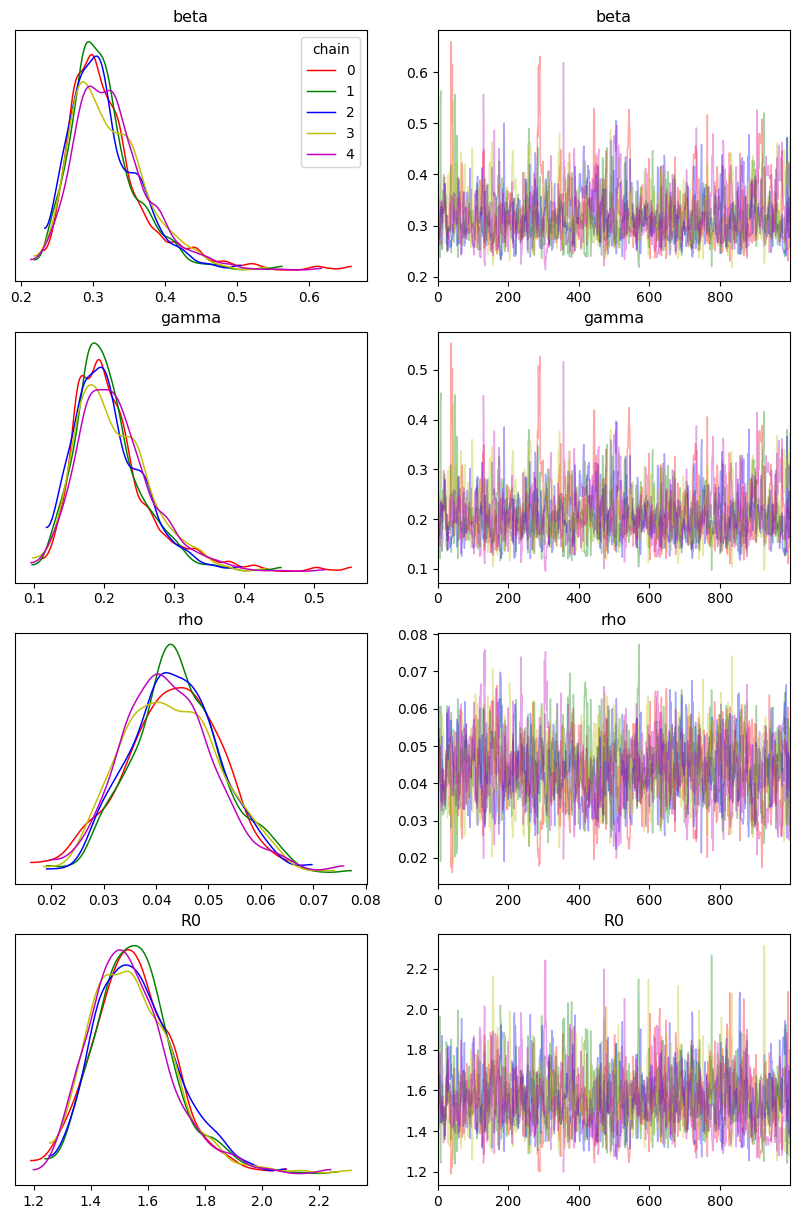

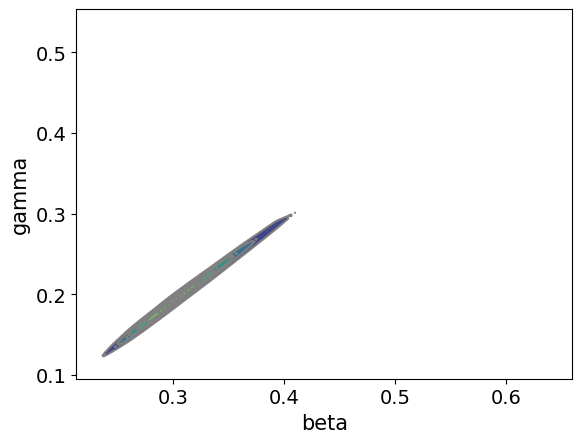

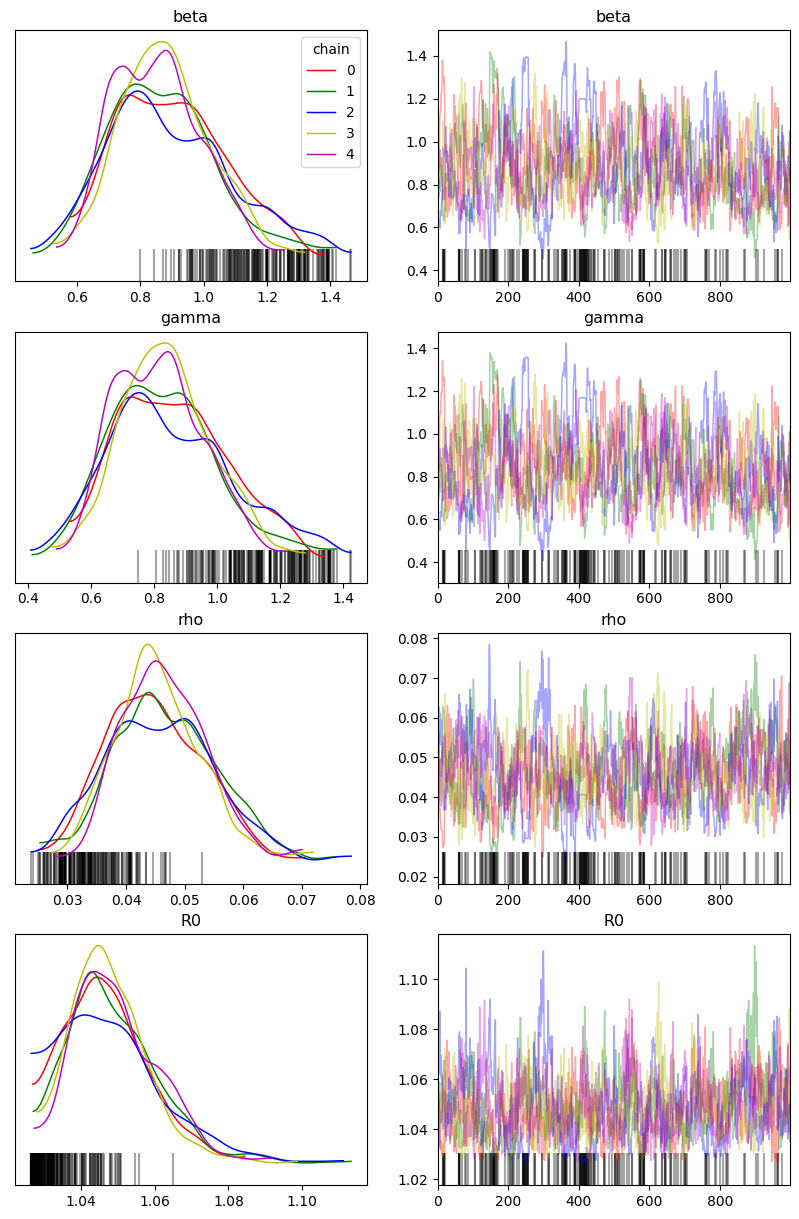

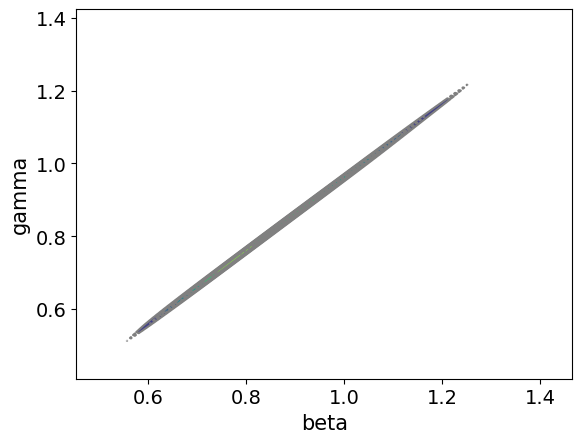

In [15]:
for index, country in enumerate(quarantine_one_results):
    for analysis in country:
        plotMCMC(analysis)

### Second Lockdown

In [10]:
def changeData(df, startDate):
    mask = (df['date'] > minusTime(startDate, 15))
    df = df.loc[mask]
    df['cumDeath'] = df['cumDeath']-df['cumDeath'].iloc[0]
    return df

In [11]:
country_names = ['France','Germany','Italy','Spain','UK']
quarantine_two_results = []
for country in country_names:
    print(country)
    df = dataset[country]['data']
    pop = dataset[country]['pop']-df['cumDeath'].iloc[0]
    print(pop)
    date = dataset[country]['sLock'][0]
    df = changeData(df, date)
    result = []

    print('=============Before=============')
    # Before Lockdown
    try:
        result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[0],gamma[2],rho[0]))
            except:
                try:
                    result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[3],gamma[3],rho[3]))
                except:
                    next
    
    print('=============After=============')
    # After Lockdown
    try:
        result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[0],gamma[2],rho[0]))
            except:
                    try:
                        result.append(runMCMC(df,pop,date,addTime(date,40),15,beta[3],gamma[3],rho[3]))
                    except:
                        next

    quarantine_two_results.append(result)

France
67413000
=============Before=============


WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

=============After=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Germany
83000000
=============Before=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

=============After=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Italy
59109993
=============Before=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

=============After=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Spain
47420000
=============Before=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

=============After=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

UK
67329999
=============Before=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

=============After=============


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

In [13]:
quarantine_two_results

[[<MultiTrace: 5 chains, 1000 iterations, 13 variables>,
  <MultiTrace: 5 chains, 1000 iterations, 13 variables>],
 [<MultiTrace: 5 chains, 1000 iterations, 13 variables>,
  <MultiTrace: 5 chains, 1000 iterations, 13 variables>],
 [<MultiTrace: 5 chains, 1000 iterations, 13 variables>,
  <MultiTrace: 5 chains, 1000 iterations, 13 variables>],
 [<MultiTrace: 5 chains, 1000 iterations, 13 variables>,
  <MultiTrace: 5 chains, 1000 iterations, 13 variables>],
 [<MultiTrace: 5 chains, 1000 iterations, 13 variables>,
  <MultiTrace: 5 chains, 1000 iterations, 13 variables>]]

In [14]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_two_results):
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_before = results_before.loc[["beta","gamma","rho",'i0','R0']]
    results_before.to_csv('mcmc_data/' + country_names[index] + '/sLock_before.csv')

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_after = results_after.loc[["beta","gamma","rho",'i0','R0']]
    results_after.to_csv('mcmc_data/' + country_names[index] + '/sLock_after.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [16]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_two_results):
    print(country_names[index])

    # Before
    print('=============Before=============')
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_before)

    # After
    print('=============After=============')
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_after)

Got error No model on context stack. trying to find log_likelihood in translation.


France
=============Before=============


mean        sd      hdi_3%     hdi_97%    r_hat
i0     6753.33580  81.39708  6590.00000  6904.00000  1.01080
beta      0.68094   0.14123     0.44429     0.94749  1.01258
gamma     0.63785   0.14175     0.39062     0.89774  1.01252
rho       0.04504   0.00907     0.02784     0.06154  1.01139
sigma   356.27114  62.59139   251.04877   475.68167  1.02190
R0        1.07090   0.01638     1.04137     1.10146  1.01147

Got error No model on context stack. trying to find log_likelihood in translation.


=============After=============


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6766.15760   77.01650  6629.00000  6920.00000  1.03684
beta      0.69375    0.03907     0.61929     0.75995  1.54900
gamma     0.67496    0.03832     0.60516     0.74339  1.54586
rho       0.05965    0.00499     0.05196     0.06892  1.52547
sigma   950.13381  102.97683   747.68176  1126.80244  1.15611
R0        1.02787    0.00137     1.02638     1.03031  1.03225

Got error No model on context stack. trying to find log_likelihood in translation.


Germany
=============Before=============


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8288.33560  96.38486  8102.00000  8461.00000  1.03565
beta      0.47288   0.08725     0.32443     0.63460  1.03333
gamma     0.43694   0.08736     0.28909     0.59875  1.03328
rho       0.04487   0.00863     0.03027     0.06258  1.03259
sigma   116.54556  20.06122    82.61447   156.00151  1.01118
R0        1.08553   0.01724     1.05675     1.12074  1.03117

Got error No model on context stack. trying to find log_likelihood in translation.


=============After=============


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8282.60300  88.49271  8124.00000  8461.00000  1.21136
beta      0.51922   0.12666     0.35324     0.74618  1.55822
gamma     0.48860   0.12665     0.32110     0.71402  1.55800
rho       0.04486   0.01095     0.02765     0.06225  1.55434
sigma   176.78550  19.74153   142.03557   212.07102  1.05031
R0        1.06675   0.01629     1.04177     1.09380  1.55294

Got error No model on context stack. trying to find log_likelihood in translation.


Italy
=============Before=============


mean          sd      hdi_3%      hdi_97%    r_hat
i0     5920.98760    78.15136  5768.00000   6059.00000  1.00703
beta      0.67993     0.47606     0.01599      1.24878  2.69326
gamma     0.64146     0.48357     0.00832      1.21084  2.48663
rho       0.04920     0.01477     0.02430      0.07527  1.76370
sigma  5605.15640  5340.67473  1022.15940  14755.58894  2.36399
R0        1.86389     2.52467     0.00873      5.42074  1.70320

Got error No model on context stack. trying to find log_likelihood in translation.


=============After=============


mean         sd      hdi_3%     hdi_97%    r_hat
i0     5924.24660   75.78528  5770.00000  6057.00000  1.03767
beta      0.89883    0.12055     0.72240     1.10111  4.13031
gamma     0.87496    0.11761     0.70268     1.07242  4.17464
rho       0.05747    0.01141     0.03977     0.07765  3.39745
sigma  3070.43989  636.56652  2206.85843  4397.11628  2.09781
R0        1.02732    0.00118     1.02618     1.02955  1.09589

Got error No model on context stack. trying to find log_likelihood in translation.


Spain
=============Before=============


mean        sd      hdi_3%     hdi_97%    r_hat
i0     4731.54600  67.62433  4597.00000  4851.00000  1.00460
beta      0.27254   0.01446     0.24586     0.29847  1.00529
gamma     0.01388   0.00845     0.00360     0.02801  1.00328
rho       0.00228   0.00134     0.00046     0.00471  1.00405
sigma    80.30646  15.14892    53.93939   107.16503  1.00089
R0       25.07110  11.93611     6.61399    47.16770  1.00314

Got error No model on context stack. trying to find log_likelihood in translation.


=============After=============


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4744.00900   70.17692  4615.00000  4872.00000  1.00398
beta      0.16905    0.02270     0.13648     0.20630  1.00306
gamma     0.07843    0.02544     0.03883     0.12271  1.00279
rho       0.04050    0.00885     0.02518     0.05810  1.00215
sigma  1450.15091  191.11018  1143.62966  1851.43791  1.00153
R0        2.28154    0.46120     1.60275     3.19178  1.00280

Got error No model on context stack. trying to find log_likelihood in translation.


UK
=============Before=============


mean        sd      hdi_3%     hdi_97%    r_hat
i0     6727.66080  58.27675  6625.00000  6829.00000  1.41532
beta      0.77336   0.04858     0.70587     0.87229  2.64713
gamma     0.75260   0.04800     0.68566     0.84965  2.64801
rho       0.05539   0.00408     0.04760     0.06146  2.58650
sigma    67.73006  20.55216    43.35697   109.19905  1.51268
R0        1.02765   0.00135     1.02638     1.02984  1.54620

Got error No model on context stack. trying to find log_likelihood in translation.


=============After=============


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6764.00620   72.52525  6617.00000  6888.00000  1.10499
beta      0.71597    0.06385     0.63315     0.80554  3.88218
gamma     0.69730    0.06218     0.61686     0.78472  3.89249
rho       0.05719    0.00757     0.04700     0.06823  3.43706
sigma   793.85656  146.89402   549.85287  1023.64516  1.70997
R0        1.02678    0.00040     1.02637     1.02751  1.02586

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got 

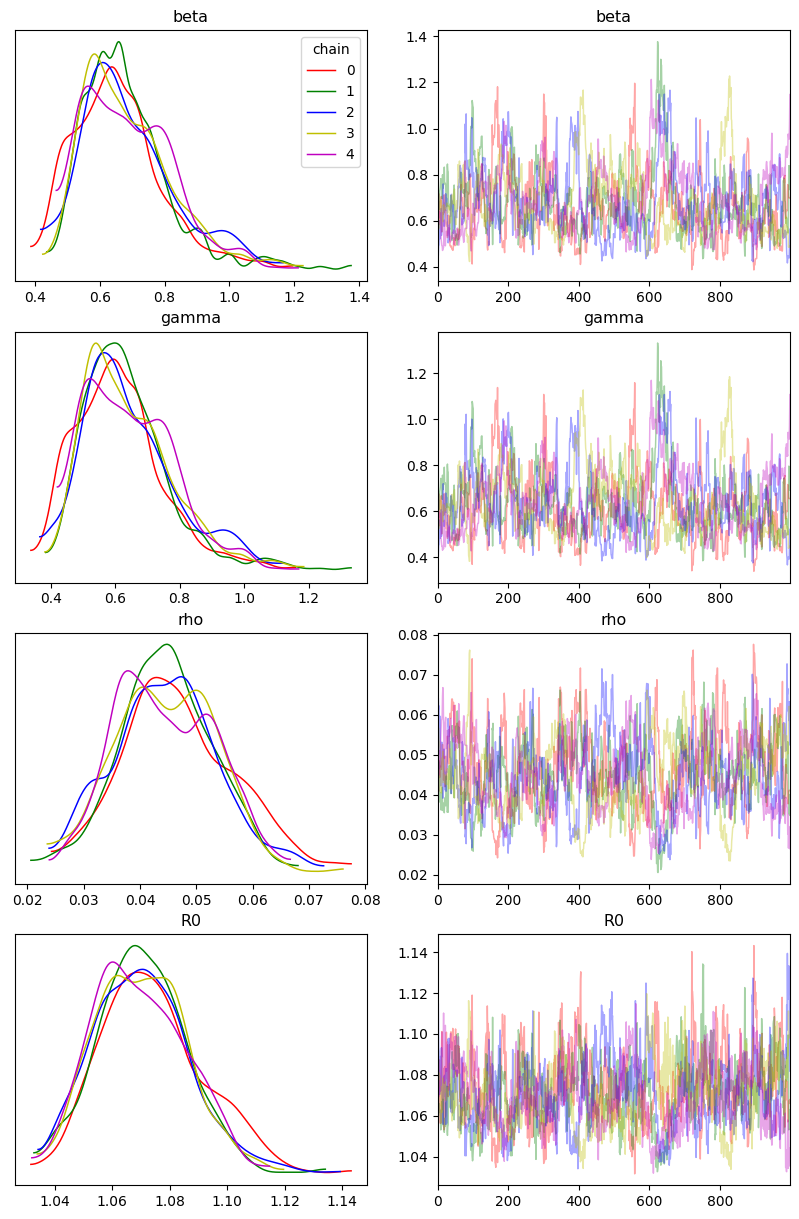

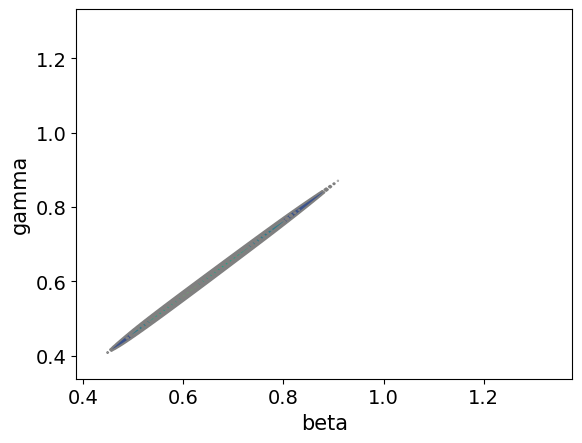

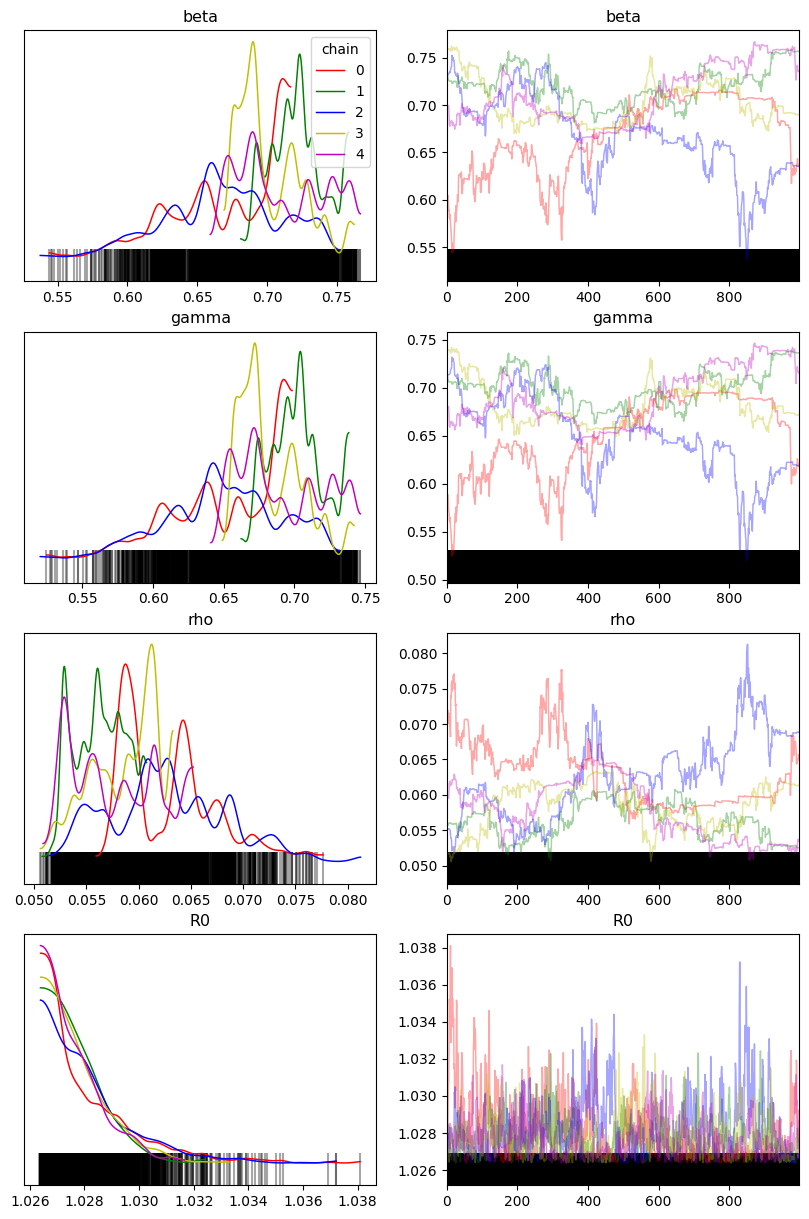

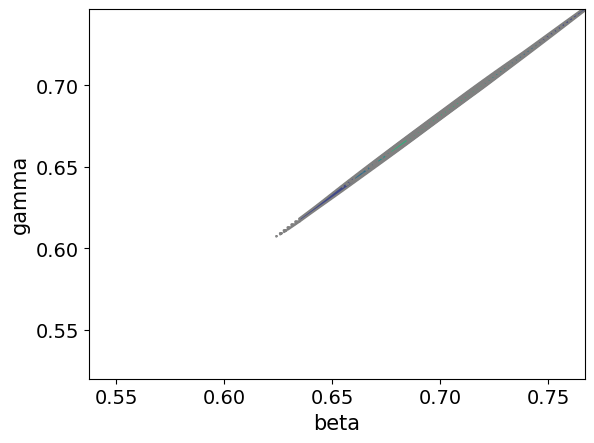

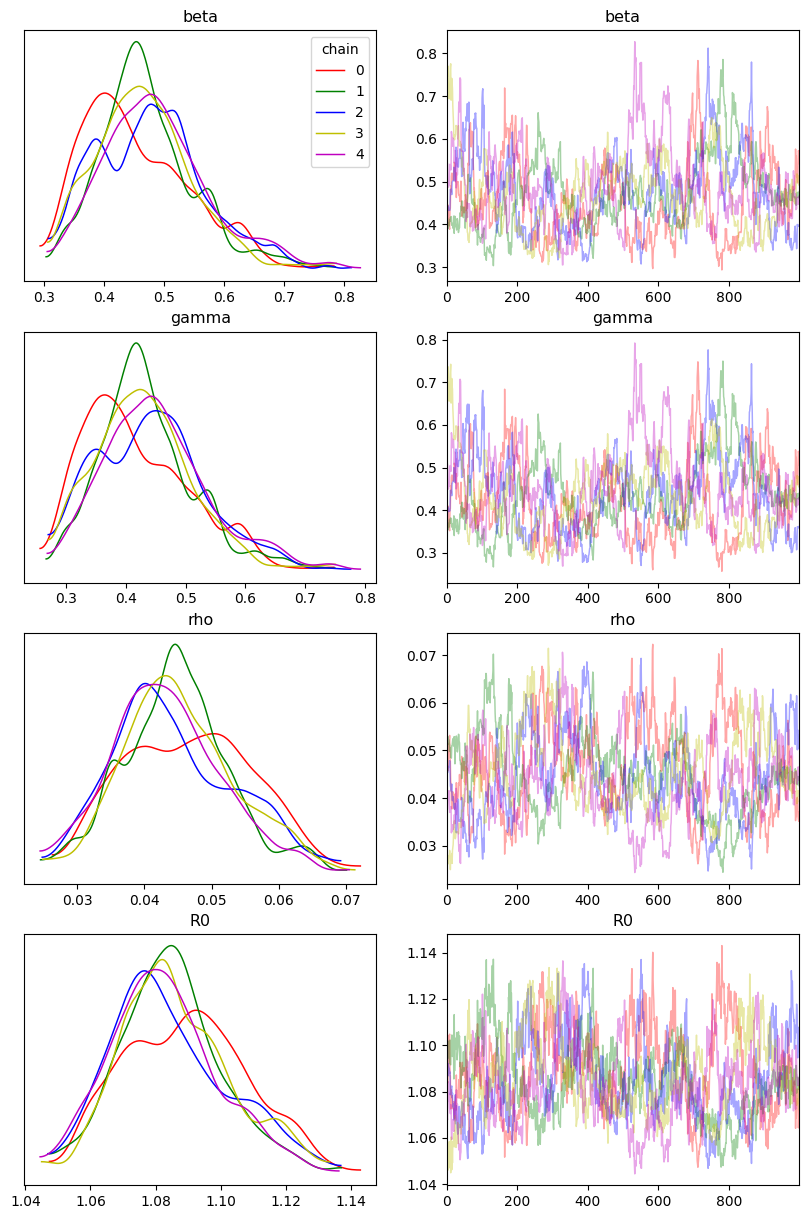

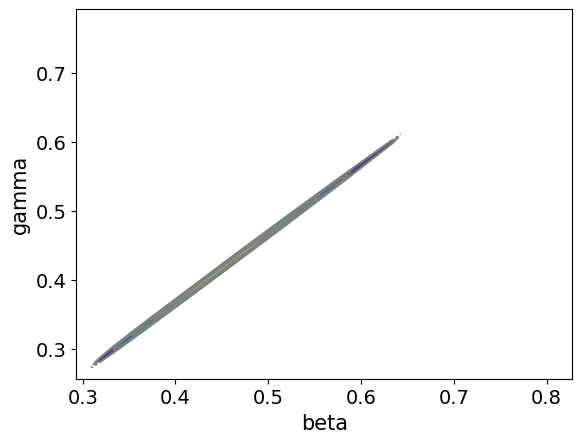

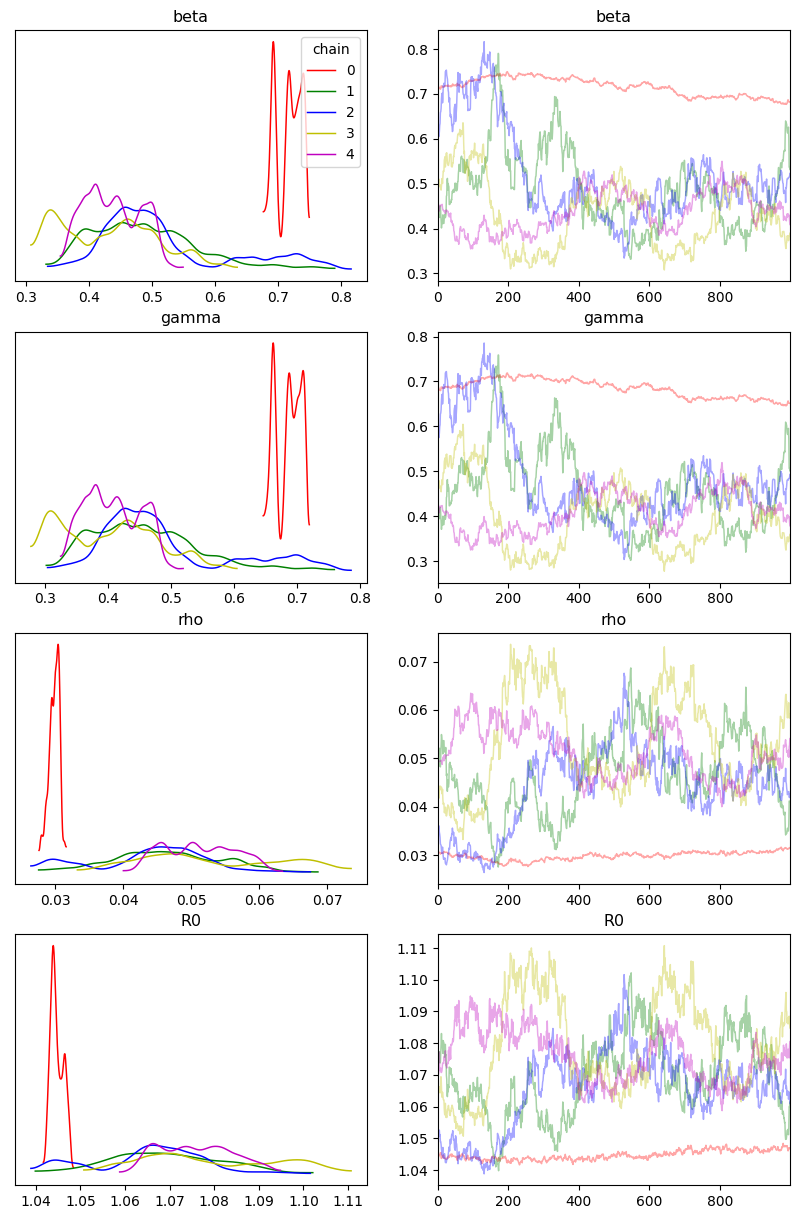

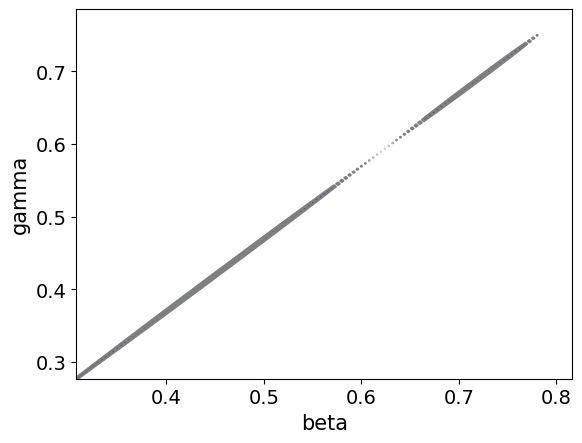

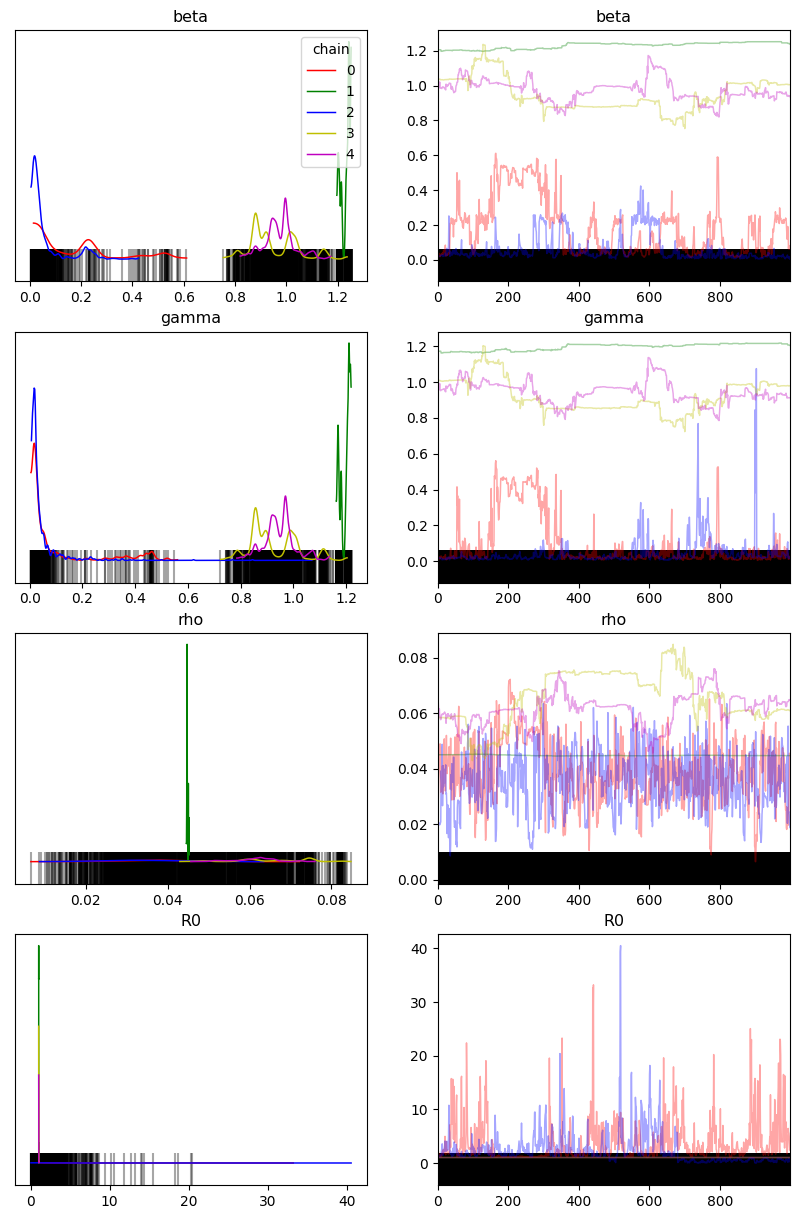

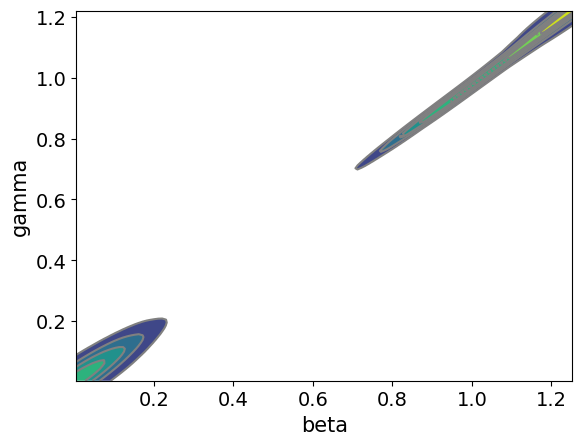

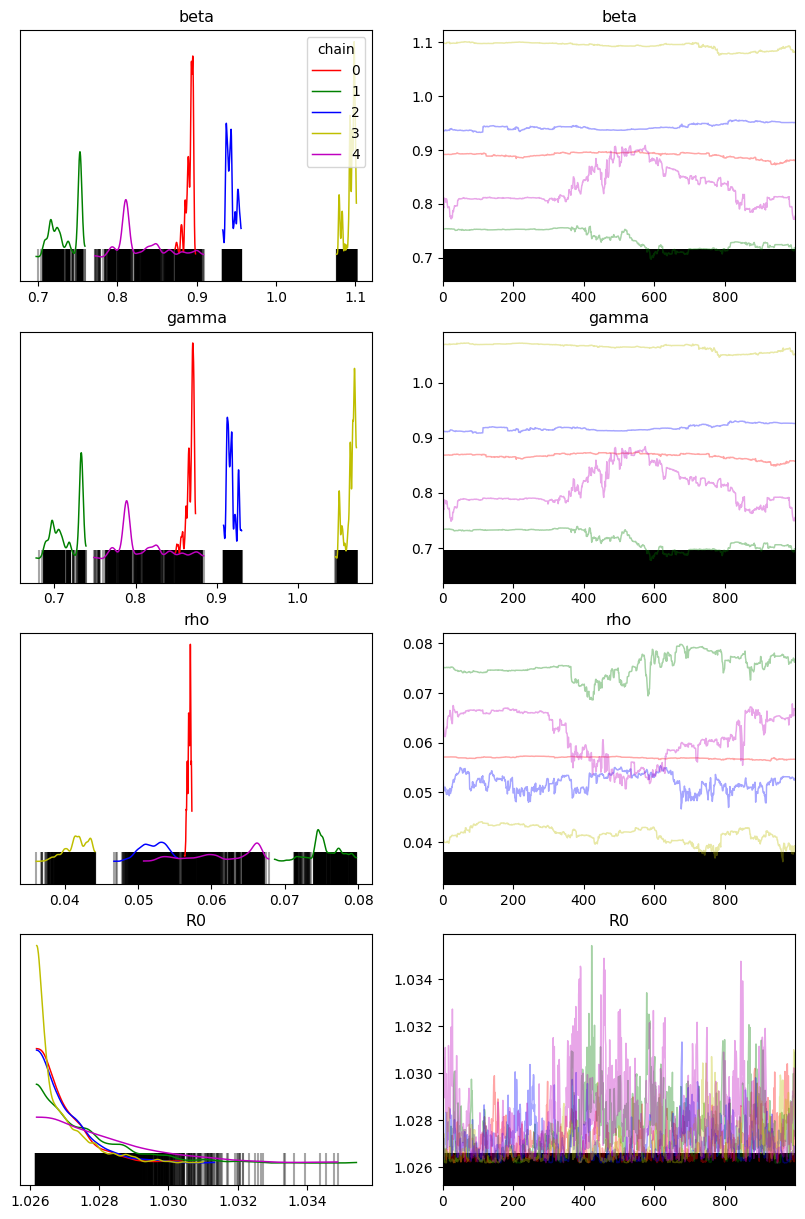

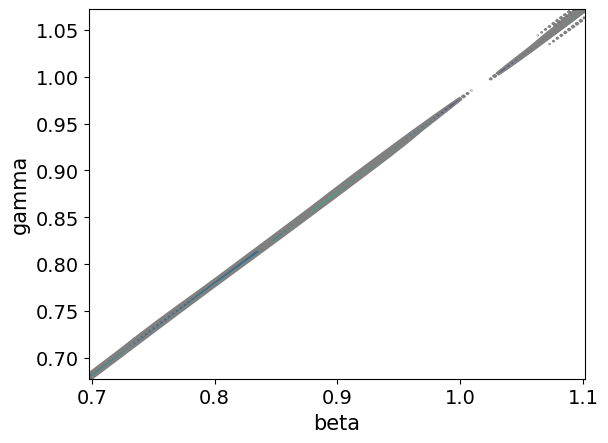

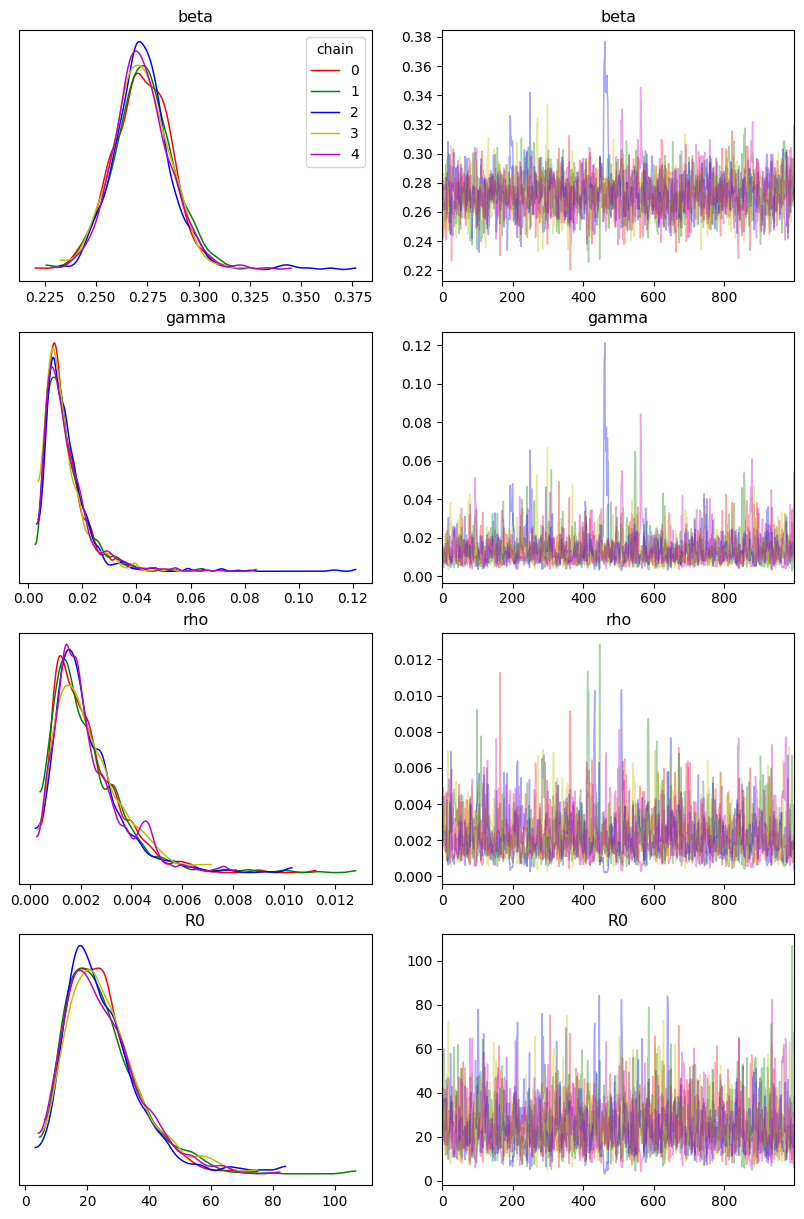

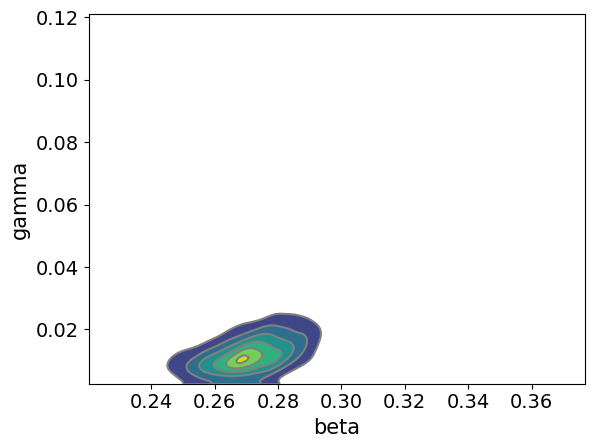

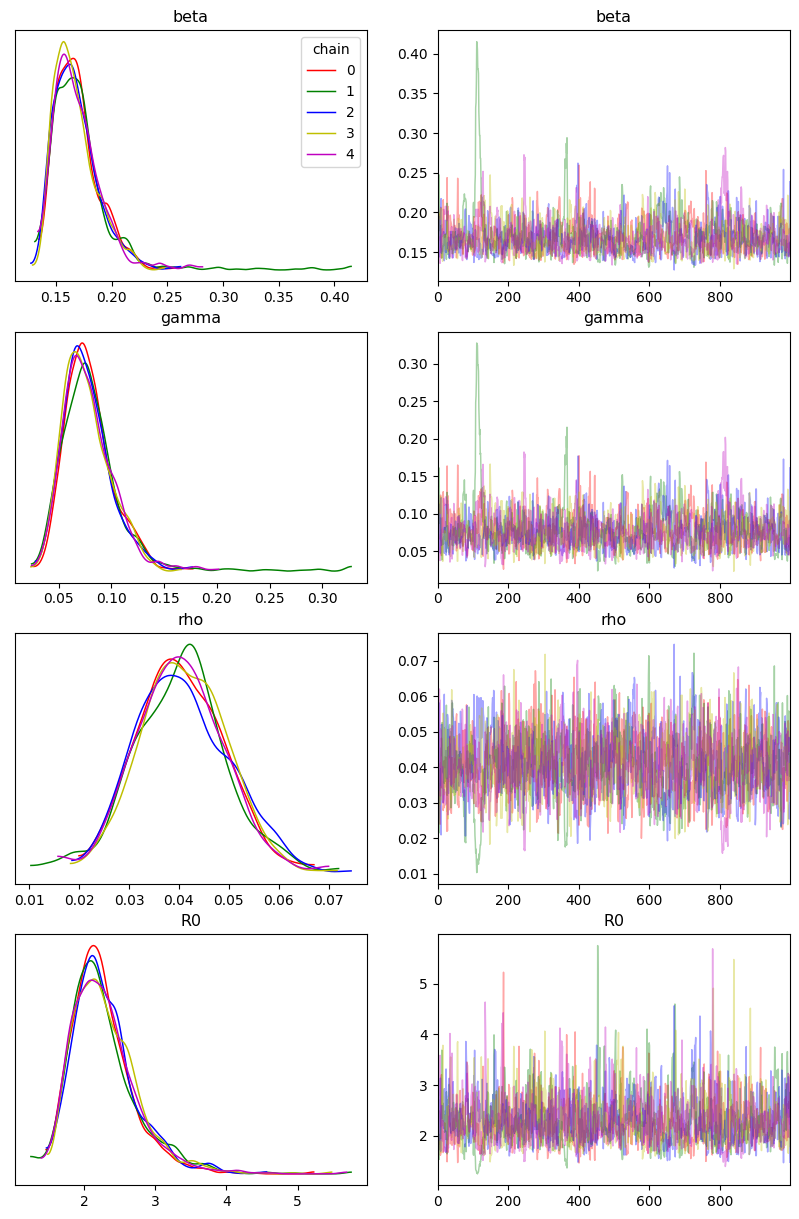

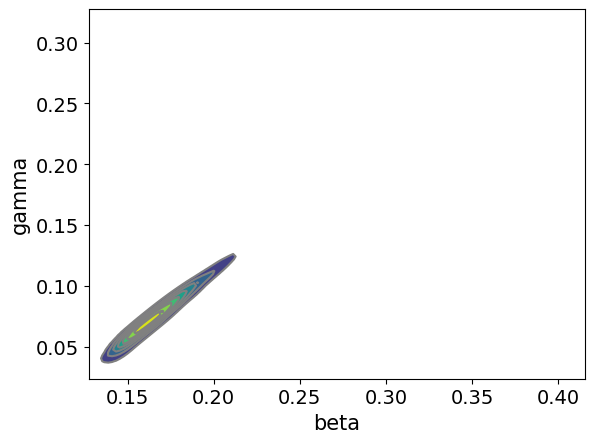

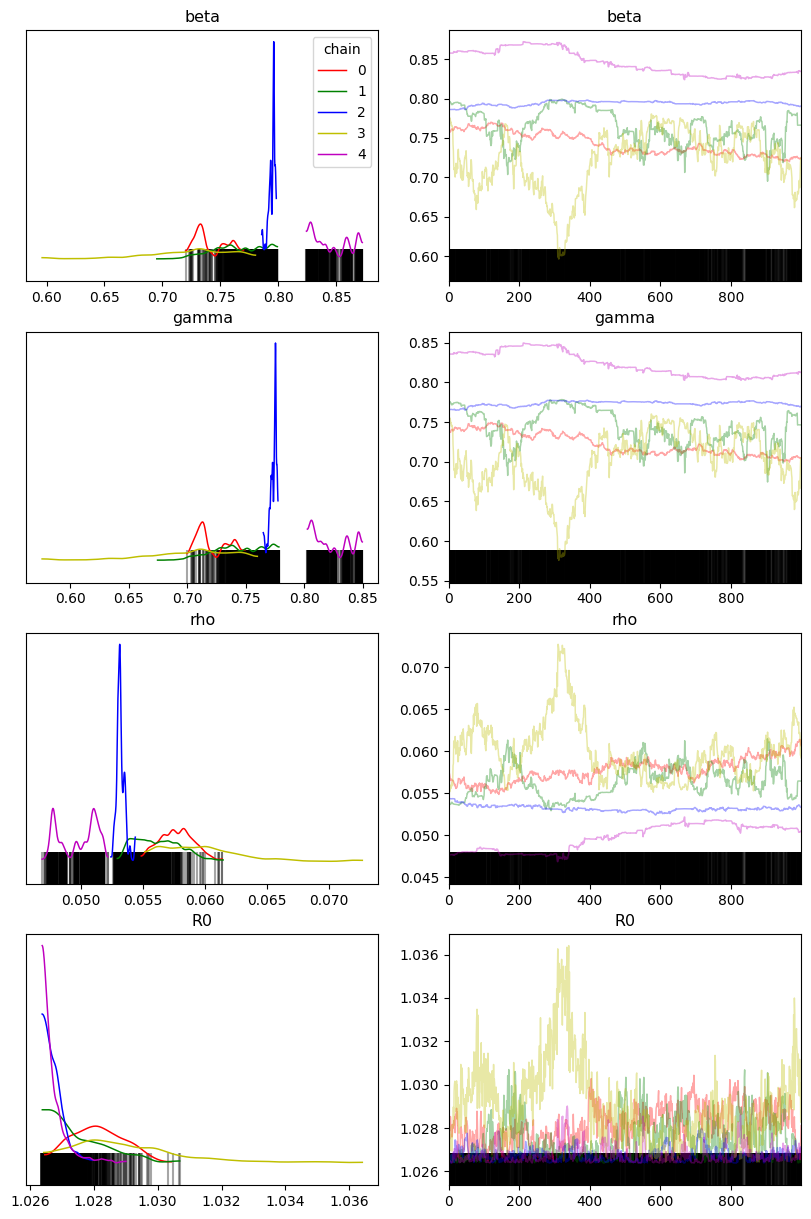

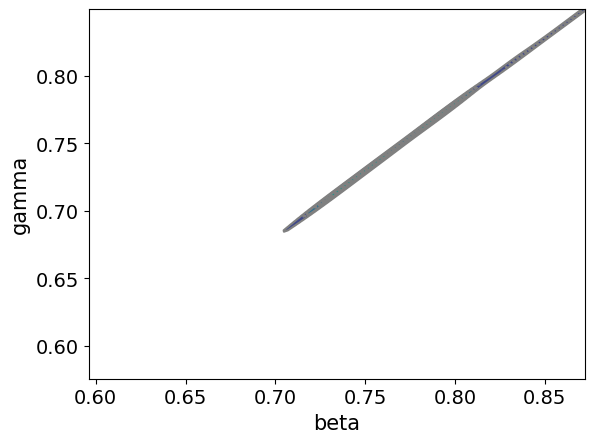

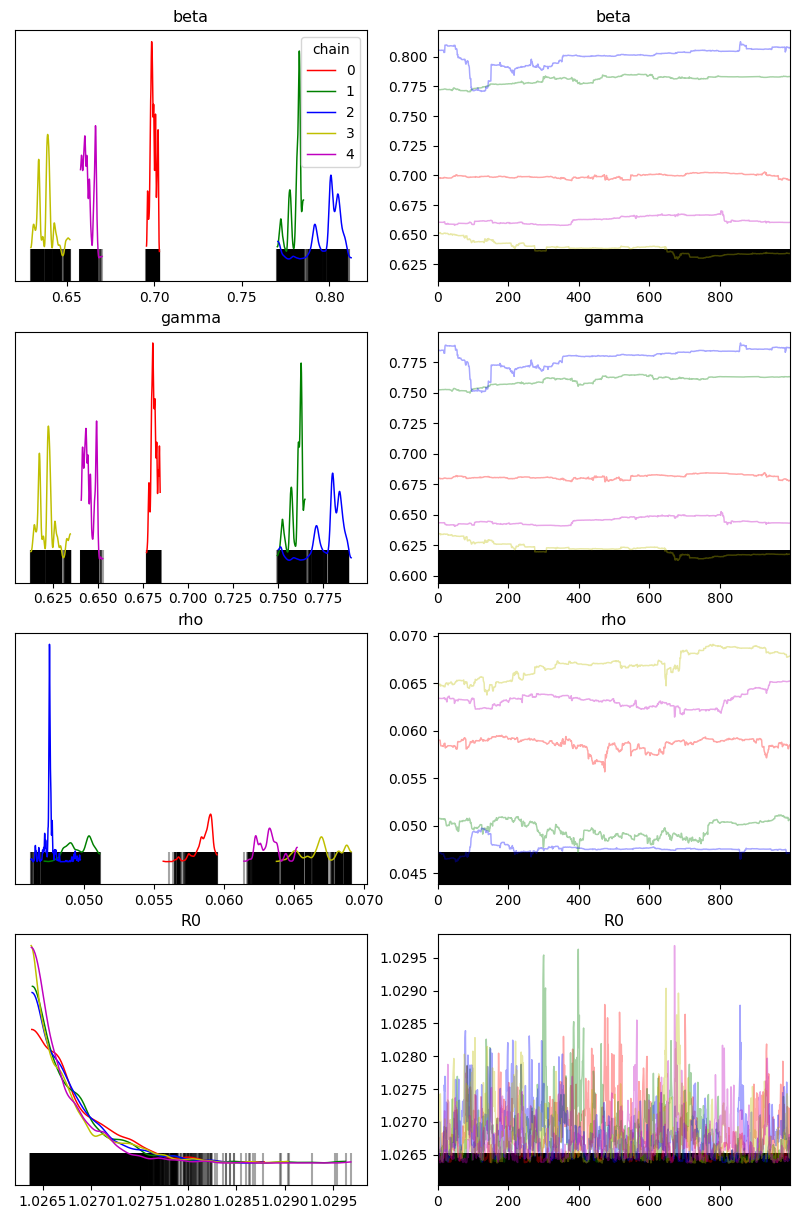

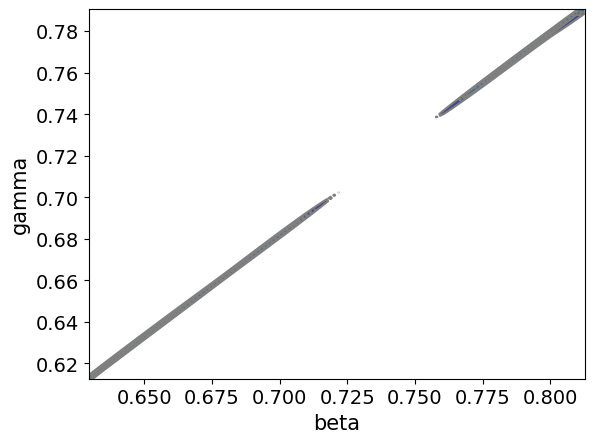

In [20]:
for index, country in enumerate(quarantine_two_results):
    for analysis in country:
        plotMCMC(analysis)